## Download logs

In [9]:
# TODO

## Parse data to pandas

In [10]:
%matplotlib inline

In [70]:
N = 10  # Number of computers

In [11]:
from io import StringIO
from matplotlib import pyplot as plt
import csv
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [112]:
def create_dataframe(csv_string, col_names): #  sep=",(?![^{]*\})",
    return pd.read_csv(StringIO(csv_string),
                       names=col_names, header=None)


def filter_logs(csv_file, keyword):
    with open(csv_file) as f:
        return ''.join([line for line in f if keyword in line]).strip()


def remove_dict(raw_input):
    assert('"' in raw_input)
    return '\n'.join([
        line[:line.find(', "')].strip() for line in raw_input.split('\n')
    ])


def get_new_tree_info(log_file):
    logs = filter_logs(log_file, "new-tree-info")
    # logs = remove_dict(logs)

    formatted = []
    for line in logs.split('\n'):
        line = line.strip()
        if '"' in line:  # first node
            line = line[:line.find('"')]
            line += str(
                float(line.rsplit(',', 2)[1].strip())**2
            )
        else:
            line = line[:line.find(", Tree")]
        formatted.append(line)
    logs = '\n'.join(formatted)

    cols = ["level", "time", "module", "log-type",
            "tree-id", "num-scanned", "gamma", "sum-gamma-squared"]  # , "tree"]
    return create_dataframe(logs, cols)


def get_performance(log_file):
    logs = filter_logs(log_file, "boosting_speed")

    cols = ["level", "time", "module", "log-type",
            "overall-duration", "overall-count", "overall-speed",
            "learner-duration", "learner-count", "learner-speed"]
    return create_dataframe(logs, cols)


def get_true_z(log_file):
    logs = filter_logs(log_file, "validate-only")

    cols = ["level", "time", "module", "log-type",
            "tree-id", "true-z", "auprc"]
    return create_dataframe(logs, cols)

def get_network_out(log_file):
    logs = filter_logs(log_file, "network-to-send-out")

    cols = ["level", "time", "module", "log-type",
            "local-name", "local-index", "score"]
    return create_dataframe(logs, cols)

def get_network_in(log_file):
    logs = filter_logs(log_file, "message-received")
    logs = remove_dict(logs)
    cols = ["level", "time", "module", "log-type",
            "local-name", "local-index", "remote-name", "remote-idx",
            "remote-ip", "score", "json-len"]  # , "model"]
    return create_dataframe(logs, cols)

def get_model_replace(log_file):
    logs = filter_logs(log_file, "model-replaced")

    cols = ["level", "time", "module", "log-type",
            "remote-score", "local-score", "remote-model-len", "local-model-len"]
    return create_dataframe(logs, cols)

In [115]:
trees = []
speed = []
true_z = []

network_in = []
network_out = []
model_replace = []

for i in range(10):
    log_path = "../logs-analysis/network/node-%d/run-network.log" % i
    validate_path = "../logs-analysis/network/node-%d/validate.log" % i

    _trees = get_new_tree_info(log_path)
    # _trees["estimated-z"] = np.exp(-(_trees["gamma"]**2).cumsum())
    _trees["node"] = i
    trees.append(_trees)

    _speed = get_performance(log_path)
    _speed["node"] = i
    speed.append(_speed)

    _true_z = get_true_z(validate_path)
    _true_z["node"] = i
    true_z.append(_true_z)

    _network_in = get_network_in(log_path)
    _network_in["node"] = i
    network_in.append(_network_in)

    _network_out = get_network_out(log_path)
    _network_out["node"] = i
    network_out.append(_network_out)

    _model_replace = get_model_replace(log_path)
    _model_replace["node"] = i
    model_replace.append(_model_replace)

trees = pd.concat(trees)
speed = pd.concat(speed)
true_z = pd.concat(true_z)

network_in = pd.concat(network_in)
network_out = pd.concat(network_out)
model_replace = pd.concat(model_replace)

trees["estimated-z"] = np.exp(-trees["sum-gamma-squared"])
trees = trees.drop(columns=["level", "module", "log-type", "sum-gamma-squared"])
true_z = true_z.drop(columns=["level", "module", "log-type", "time"])
speed = speed.drop(columns=["level", "module", "log-type"])

network_in = network_in.drop(columns=["level", "module", "log-type"])
network_out = network_out.drop(columns=["level", "module", "log-type"])
model_replace = model_replace.drop(columns=["level", "module", "log-type"])

In [116]:
trees.head()

,time,tree-id,num-scanned,gamma,node,estimated-z
0,1.014435e+06,1,10000,0.496800,0,0.781289
1,1.014587e+06,33,47000,0.019771,0,0.716250
2,1.014602e+06,75,34000,0.010507,0,0.668496
3,1.014602e+06,77,311000,0.010507,0,0.668155
4,1.014605e+06,88,32000,0.009456,0,0.660981


In [117]:
import pickle


with open("tree_info_local.pkl", 'rb') as f:
    tree_info_local = pickle.load(f)
tree_info_local["time"] -= tree_info_local["time"][0]
max_range = tree_info_local["range"].max()
tree_info_local = tree_info_local[tree_info_local["range"] == max_range]

In [129]:
tree_info = trees.merge(true_z, on=["tree-id", "node"], how="outer") \
                 .merge(
                     model_replace.rename(columns={"remote-model-len": "tree-id"}),
                     on=["tree-id", "node"], how="outer"
                 ) \
                 .sort_values(by=['node', 'tree-id'])
tree_info["time"] = tree_info["time_x"].fillna(tree_info["time_y"])
tree_info["time"] -= tree_info["time"].iloc[0]
tree_info = tree_info.drop(
    columns=["time_x", "time_y"])
tree_info[["estimated-z", "true-z", "auprc"]] = \
    tree_info[["estimated-z", "true-z", "auprc"]].fillna(method="pad")

In [132]:
tree_info.tail()

,tree-id,num-scanned,gamma,node,estimated-z,true-z,auprc,remote-score,local-score,local-model-len,time
4582,496,NaN,NaN,9,0.606299,0.067966,0.079316,0.505740,0.505605,495.0,515.055116
4583,497,NaN,NaN,9,0.606299,0.067966,0.079316,0.506037,0.505740,496.0,515.169395
4584,498,NaN,NaN,9,0.606299,0.067966,0.079316,0.506335,0.506037,497.0,515.255137
4585,499,NaN,NaN,9,0.606299,0.067966,0.079316,0.506469,0.506335,498.0,515.279077
1001,500,NaN,NaN,9,0.606299,0.067956,0.079384,0.506766,0.506469,499.0,515.362750


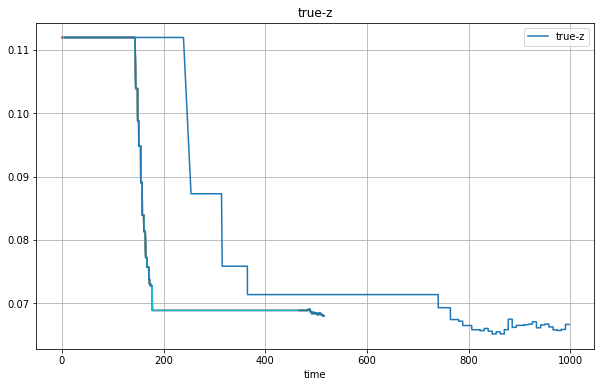

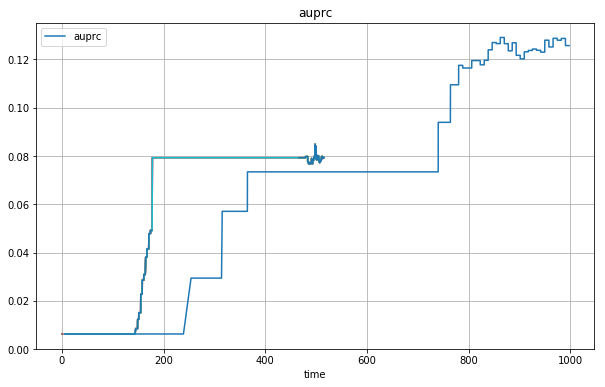

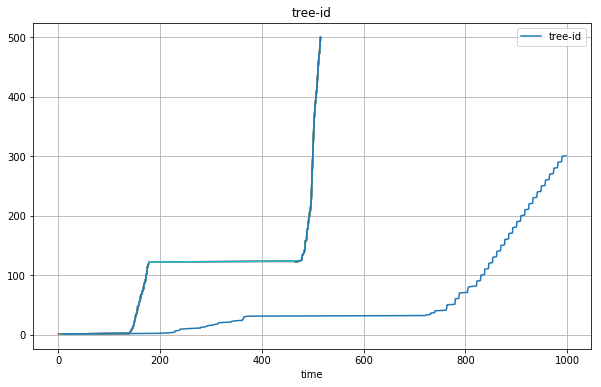

In [141]:
for field in ["true-z", "auprc", "tree-id"]:
    """
    plt.figure(figsize=(10, 10))
    ax1=plt.subplot(211)
    tree_info_local.plot(
        x="time", y=field,
        grid=True,
        ax=ax1, title=field
    );
    ax2=plt.subplot(212)
    for i in range(N):
        df = tree_info[tree_info["node"] == i]
        if df.shape[0]:
            df.plot(
                x="time", y=field,
                grid=True,
                ax=ax2, title=field,
                sharex=ax1
            );
    """
    plt.figure(figsize=(10, 6))
    ax=plt.subplot(111)
    tree_info_local.plot(
        x="time", y=field,
        grid=True,
        ax=ax, title=field
    );
    for i in range(N):
        df = tree_info[tree_info["node"] == i]
        if df.shape[0]:
            df.plot(
                x="time", y=field,
                grid=True,
                ax=ax, title=field,
                legend=None
            );

    # ax1.set_xlim(0, 600)
    # ax2.set_xlim(0, 600)

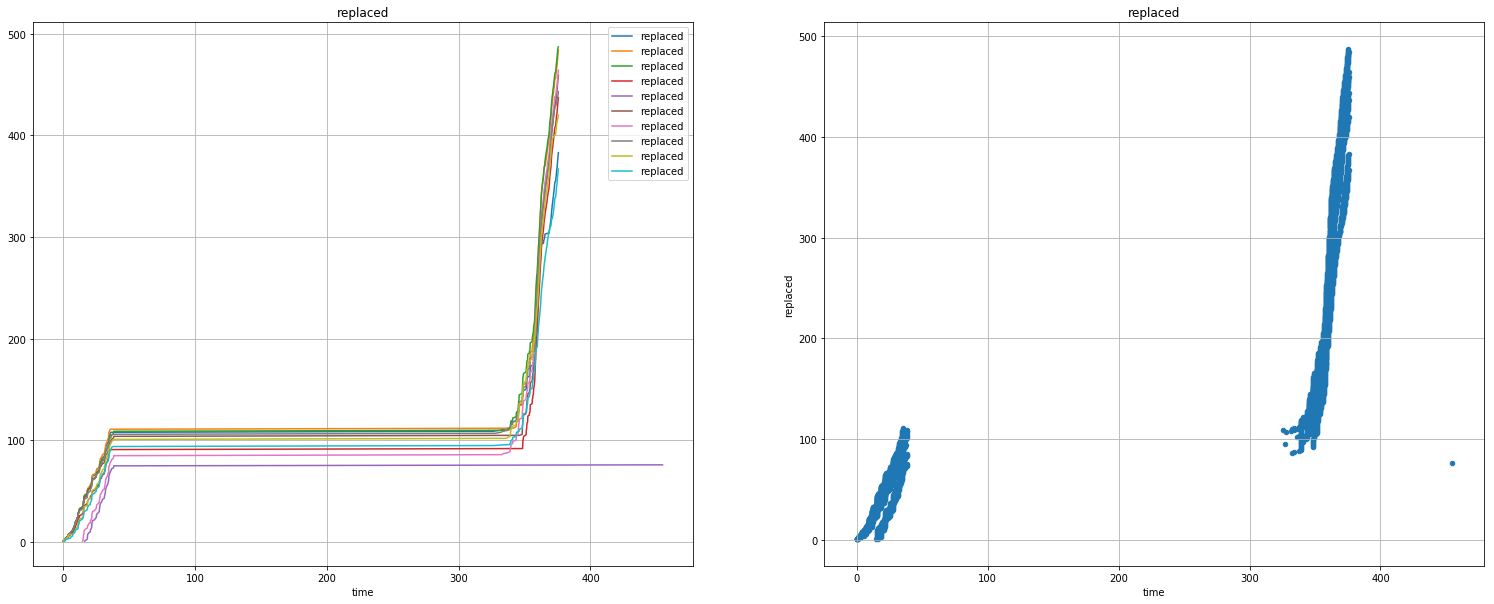

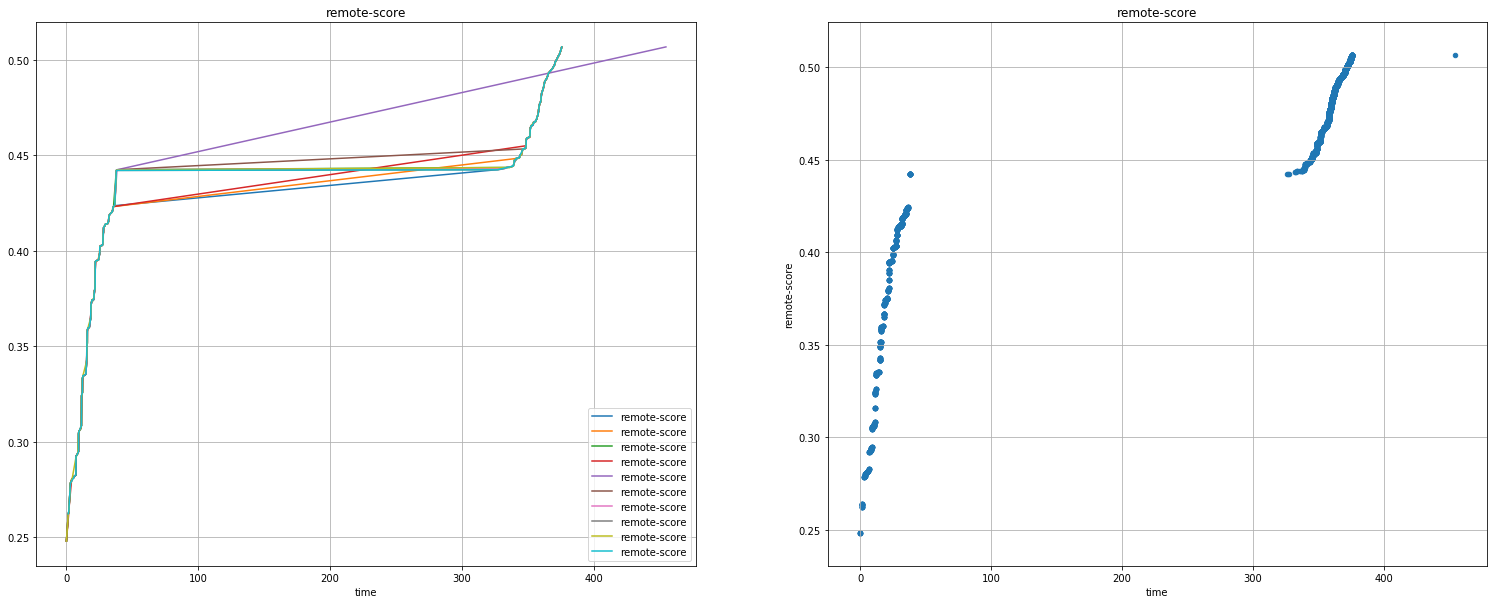

In [170]:
model_replace["time"] -= model_replace["time"].iloc[0]
for field in ["replaced", "remote-score"]:
    plt.figure(figsize=(26, 10))
    ax1 = plt.subplot(121)
    ax2=plt.subplot(122)
    for i in range(N):
        df = model_replace[model_replace["node"] == i]
        df["replaced"] = 1
        df["replaced"] = df["replaced"].cumsum()
        if df.shape[0]:
            df.plot(
                x="time", y=field,
                grid=True,
                ax=ax1, title=field
            );
            df.plot(
                kind="scatter",
                x="time", y=field,
                grid=True,
                ax=ax2, title=field
            );